In [37]:
import pandas as pd

import numpy as np
import sys, os
import re

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib

import statsmodels.api as sm
import statsmodels.stats.multitest as statsmulti

matplotlib.rcParams['xtick.major.size'] = 8
matplotlib.rcParams['xtick.major.width'] = 2.5
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['xtick.minor.size'] = 4
matplotlib.rcParams['xtick.minor.width'] = 1
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = 'Arial'

In [38]:
from matplotlib.patches import PathPatch

def adjust_box_widths(g, fac):
    """
    Adjust the widths of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.array_equal(l.get_xdata(), [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])

## Evaluate impact of splicing on measurements from original PTRE-seq study

In [3]:
# Import splicing measurements
HELA = pd.read_csv('ptreseq_splicing_quantification/HELA_2rep_fraction.txt', sep = '\t')
HELA['spliced_fraction'] = 1 - HELA['fraction']
HELA = HELA[HELA['best_category']=='full_length']

In [4]:
# Import expression measurements from original PTRE-seq study
# RNA expression is computed as previously described

# read RNA expression data
ptreseq_rna_count = pd.read_excel('data/sup3_readscount_HeLa_total.xlsx', engine = 'openpyxl')
ptreseq_rna_count = ptreseq_rna_count[ptreseq_rna_count['counts_RNA']>10]

# read plasmid
ptreseq_dna_count = pd.read_excel('data/sup2_readscount_plasmid.xlsx', engine = 'openpyxl')
ptreseq_dna_count = ptreseq_dna_count.groupby(['Barcode'])['counts_Plasmid'].mean().reset_index()

# read barcode
bc = pd.read_csv('data/barcode_indexed.txt', sep = '\t', names = ['reporter', 'Barcode'])

# calculate median expression
# merge
ptreseq_count = ptreseq_rna_count.merge(ptreseq_dna_count, on = ['Barcode'], suffixes = ['_RNA', '_DNA'])
ptreseq_count = ptreseq_count.merge(bc, on = 'Barcode')

# rename some plasmids
rename_dict = {'Lpcx1': '7pcx1', 'Lpcx2': '7pcx2', 'Lpcx4': '7pcx4'}

def rename_f(p):
    if p in rename_dict.keys():
        return rename_dict[p]
    else:
        return p
    
ptreseq_count['RE'] = ptreseq_count['RE_Identity'].apply(lambda g: rename_f(g))

# normalize raw count by plasmid count
ptreseq_count['RNA/DNA'] = ptreseq_count['counts_RNA']/ptreseq_count['counts_Plasmid']

# Calculate BBBB median and normalize expression
BBBB = ptreseq_count[ptreseq_count['RE']=='BBBB']
median_exp = BBBB['RNA/DNA'].median()

# normalized by median of BBBB normalized count
ptreseq_count['L2FC'] = np.log2(ptreseq_count['RNA/DNA']/median_exp)

# calculate median
ptreseq_count_median = ptreseq_count.groupby('RE')['L2FC'].median()

###################################################################################################################
# translation efficiency is computed as previously described

# read polysome association data
ptreseq_rna_TE = pd.read_excel('data/sup4_readscount_HeLa_polysome.xlsx', engine = 'openpyxl')
ptreseq_rna_TE = ptreseq_rna_TE[ptreseq_rna_TE['counts_PARNA']>10]

# merge
ptreseq_TE = ptreseq_rna_TE.merge(ptreseq_dna_count, on = ['Barcode'], suffixes = ['_RNA', '_DNA'])
ptreseq_TE = ptreseq_TE.merge(bc, on = 'Barcode')

# rename some plasmids
rename_dict = {'Lpcx1': '7pcx1', 'Lpcx2': '7pcx2', 'Lpcx4': '7pcx4'}

def rename_f(p):
    if p in rename_dict.keys():
        return rename_dict[p]
    else:
        return p
    
ptreseq_TE['RE'] = ptreseq_TE['RE_Identity'].apply(lambda g: rename_f(g))

# normalize raw count by plasmid count
ptreseq_TE['RNA/DNA'] = ptreseq_TE['counts_PARNA']/ptreseq_count['counts_Plasmid']

# Calculate BBBB median and normalize expression
BBBB = ptreseq_TE[ptreseq_TE['RE']=='BBBB']
median_exp = BBBB['RNA/DNA'].median()

# normalized by median of BBBB normalized count
ptreseq_TE['L2FC'] = np.log2(ptreseq_TE['RNA/DNA']/median_exp)

# calculate median
ptreseq_TE_median = ptreseq_TE.groupby('RE')['L2FC'].median()

## Figure 4D: plot rna expression all vs ns reporters by number of ARE modules

In [5]:
# Merge expression and splicing measurements
expression = HELA[['RE', 'spliced_fraction']].merge(
    ptreseq_count_median.to_frame().reset_index(), 
    on = 'RE',
)

expression = expression[expression['RE'].str.contains('^[BLpSA]{4}$')].reset_index(drop = True)

# Get count of modules for each reporter
expression['Acount'] = expression['RE'].apply(lambda g: g.count('A'))
expression['pcount'] = expression['RE'].apply(lambda g: g.count('p'))
expression['Lcount'] = expression['RE'].apply(lambda g: g.count('L'))
expression['Scount'] = expression['RE'].apply(lambda g: g.count('S'))
expression['Bcount'] = expression['RE'].apply(lambda g: g.count('B'))
expression['hue'] = 'all'
# subset reporters < 1% spliced
ns_expression = expression[expression['spliced_fraction']<0.01].reset_index(drop=True)
ns_expression['hue'] = 'ns'

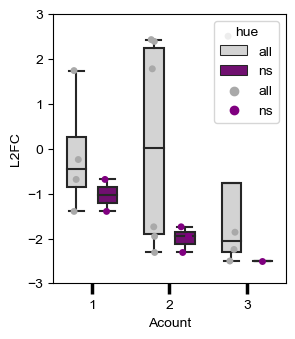

In [18]:
# rna exp for all reporters 
expression_A = expression[(expression['pcount']==0)&(expression['Lcount']==0)&(expression['Scount']==0)]

# rna exp for reporters with less than 1% splicing efficiency
ns_expression_A = ns_expression[(ns_expression['pcount']==0)&(ns_expression['Lcount']==0)&(ns_expression['Scount']==0)]

toplot = pd.concat([expression_A, ns_expression_A]).reset_index(drop = True)

f, ax = plt.subplots(figsize = (3, 3.5))

sns.boxplot(
    data = toplot, 
    x = 'Acount', 
    y = 'L2FC', 
    hue = 'hue', 
    order = [1, 2, 3],
    flierprops = {'marker': 'o'},
    showfliers=False,
    palette = ['lightgrey', 'purple'],
    ax = ax)

sns.stripplot(
    data = toplot, 
    x = 'Acount', 
    y = 'L2FC', 
    hue = 'hue', 
    order = [1, 2, 3],
    palette = ['darkgrey', 'purple'],
    dodge = True,
    ax = ax)

adjust_box_widths(f, 0.65)

ax.set_ylim(-3, 3)

f.savefig('PLOTS/Fig_4D_1.pdf', transparent = True)

## Figure 4E: plot TE all vs ns reporters by number of ARE modules

In [9]:
# Merge expression and splicing measurements
translation = HELA[['RE', 'spliced_fraction']].merge(
    ptreseq_TE_median.to_frame().reset_index(), 
    on = 'RE',
)

translation = translation[translation['RE'].str.contains('^[BLpSA]{4}$')].reset_index(drop = True)

# Get count of modules for each reporter
translation['Acount'] = translation['RE'].apply(lambda g: g.count('A'))
translation['pcount'] = translation['RE'].apply(lambda g: g.count('p'))
translation['Lcount'] = translation['RE'].apply(lambda g: g.count('L'))
translation['Scount'] = translation['RE'].apply(lambda g: g.count('S'))
translation['Bcount'] = translation['RE'].apply(lambda g: g.count('B'))
translation['hue'] = 'all'
# subset reporters < 1% spliced
ns_translation = translation[translation['spliced_fraction']<0.01].reset_index(drop=True)
ns_translation['hue'] = 'ns'

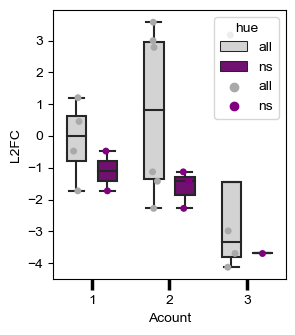

In [19]:
# rna exp for all reporters 
translation_A = translation[(translation['pcount']==0)&(translation['Lcount']==0)&(translation['Scount']==0)]

# rna exp for reporters with less than 1% splicing efficiency
ns_translation_A = ns_translation[(ns_translation['pcount']==0)&(ns_translation['Lcount']==0)&(ns_translation['Scount']==0)]

toplot = pd.concat([translation_A, ns_translation_A]).reset_index(drop = True)

f, ax = plt.subplots(figsize = (3, 3.5))

sns.boxplot(
    data = toplot, 
    x = 'Acount', 
    y = 'L2FC', 
    hue = 'hue', 
    order = [1, 2, 3],
    flierprops = {'marker': 'o'},
    showfliers=False,
    palette = ['lightgrey', 'purple'],
    ax = ax)

sns.stripplot(
    data = toplot, 
    x = 'Acount', 
    y = 'L2FC', 
    hue = 'hue', 
    order = [1, 2, 3],
    palette = ['darkgrey', 'purple'],
    dodge = True,
    ax = ax)

adjust_box_widths(f, 0.65)

f.savefig('PLOTS/Fig_4D_2.pdf', transparent = True)

## Figure S5B and S5C: relationship between ARE and Let-7 or PUM

In [20]:
# Make a copy of the dataframe
df_for_model = expression.copy()

# get identity for RE at each position
df_for_model['P1'] = df_for_model['RE'].apply(lambda g: g[0])
df_for_model['P2'] = df_for_model['RE'].apply(lambda g: g[1])
df_for_model['P3'] = df_for_model['RE'].apply(lambda g: g[2])
df_for_model['P4'] = df_for_model['RE'].apply(lambda g: g[3])

# formula considers RE identity, position, and interaction
formula = "L2FC ~ C(P1, Treatment(reference='B'))*C(P2, Treatment(reference='B')) \
                + C(P1, Treatment(reference='B'))*C(P3, Treatment(reference='B')) \
                + C(P1, Treatment(reference='B'))*C(P4, Treatment(reference='B')) \
                + C(P2, Treatment(reference='B'))*C(P3, Treatment(reference='B')) \
                + C(P2, Treatment(reference='B'))*C(P4, Treatment(reference='B')) \
                + C(P3, Treatment(reference='B'))*C(P4, Treatment(reference='B'))"


# fit model for all reporters
model = sm.formula.glm(formula = formula, 
                       data = df_for_model, 
                       family=sm.families.Gaussian()).fit()

# fit model for reporters < 1% spliced
df_for_model_nosplice = df_for_model[df_for_model['spliced_fraction']<0.01]
model_nosplice = sm.formula.glm(formula = formula, 
                                data = df_for_model_nosplice, 
                                family=sm.families.Gaussian()).fit()

In [21]:
def retrieve_interaction_param(param):
    # function to retrieve interaction coefficients
    if ':' in param:
        spl = param.split(':')
        
        RE1_pos = re.search(r'\(P(\d+),', spl[0]).group(1)
        RE1_ID = re.search(r'\[T\.([A-Za-z])\]', spl[0]).group(1)
        
        RE2_pos = re.search(r'\(P(\d+),', spl[1]).group(1)
        RE2_ID = re.search(r'\[T\.([A-Za-z])\]', spl[1]).group(1)
        
        return int(RE1_pos), RE1_ID, int(RE2_pos), RE2_ID
    
    else: 
        return np.nan, np.nan, np.nan, np.nan
    
# create matrix for model of all reporters
# for parameter values
ARE_PUM = pd.DataFrame(columns = [1, 2, 3, 4], index = [1, 2, 3, 4])
ARE_LET7 = pd.DataFrame(columns = [1, 2, 3, 4], index = [1, 2, 3, 4])
# for p values
ARE_PUM_pval = pd.DataFrame(columns = [1, 2, 3, 4], index = [1, 2, 3, 4])
ARE_LET7_pval = pd.DataFrame(columns = [1, 2, 3, 4], index = [1, 2, 3, 4])

for idx in model.params.index:
    RE1_pos, RE1_ID, RE2_pos, RE2_ID = retrieve_interaction_param(idx)
    param = model.params[idx]
    
    if model.pvalues[idx] < 0.001:
        pval = '***'
    elif model.pvalues[idx] < 0.01:
        pval = '**'
    elif model.pvalues[idx] < 0.05:
        pval = '*'
    else:
        pval = 'n.s.'
    
    if RE1_ID == 'p' and RE2_ID == 'A':
        ARE_PUM.loc[ARE_PUM.index==RE1_pos, RE2_pos] = param
        ARE_PUM_pval.loc[ARE_PUM_pval.index==RE1_pos, RE2_pos] = pval 
    elif RE1_ID == 'A' and RE2_ID == 'p':
        ARE_PUM.loc[ARE_PUM.index==RE2_pos, RE1_pos] = param
        ARE_PUM_pval.loc[ARE_PUM_pval.index==RE2_pos, RE1_pos] = pval 
    elif RE1_ID == 'L' and RE2_ID == 'A':
        ARE_LET7.loc[ARE_LET7.index==RE1_pos, RE2_pos] = param
        ARE_LET7_pval.loc[ARE_LET7_pval.index==RE1_pos, RE2_pos] = pval 
    elif RE1_ID == 'A' and RE2_ID == 'L':
        ARE_LET7.loc[ARE_LET7.index==RE2_pos, RE1_pos] = param
        ARE_LET7_pval.loc[ARE_LET7_pval.index==RE2_pos, RE1_pos] = pval 
        
ARE_PUM.fillna(0, inplace = True)  
ARE_LET7.fillna(0, inplace = True)  
ARE_PUM_pval.fillna('', inplace = True)  
ARE_LET7_pval.fillna('', inplace = True)  

# create matrix for model of not spliced reporters
# for parameter values
ARE_PUM_ns = pd.DataFrame(columns = [1, 2, 3, 4], index = [1, 2, 3, 4])
ARE_LET7_ns = pd.DataFrame(columns = [1, 2, 3, 4], index = [1, 2, 3, 4])
# for p values
ARE_PUM_pval_ns = pd.DataFrame(columns = [1, 2, 3, 4], index = [1, 2, 3, 4])
ARE_LET7_pval_ns = pd.DataFrame(columns = [1, 2, 3, 4], index = [1, 2, 3, 4])

for idx in model_nosplice.params.index:
    RE1_pos, RE1_ID, RE2_pos, RE2_ID = retrieve_interaction_param(idx)
    param = model_nosplice.params[idx]
    
    if model.pvalues[idx] < 0.001:
        pval = '***'
    elif model.pvalues[idx] < 0.01:
        pval = '**'
    elif model.pvalues[idx] < 0.05:
        pval = '*'
    else:
        pval = 'n.s.'
    
    if RE1_ID == 'p' and RE2_ID == 'A':
        ARE_PUM_ns.loc[ARE_PUM_ns.index==RE1_pos, RE2_pos] = param
        ARE_PUM_pval_ns.loc[ARE_PUM_pval_ns.index==RE1_pos, RE2_pos] = pval 
    elif RE1_ID == 'A' and RE2_ID == 'p':
        ARE_PUM_ns.loc[ARE_PUM_ns.index==RE2_pos, RE1_pos] = param
        ARE_PUM_pval_ns.loc[ARE_PUM_pval_ns.index==RE2_pos, RE1_pos] = pval 
    elif RE1_ID == 'L' and RE2_ID == 'A':
        ARE_LET7_ns.loc[ARE_LET7_ns.index==RE1_pos, RE2_pos] = param
        ARE_LET7_pval_ns.loc[ARE_LET7_pval_ns.index==RE1_pos, RE2_pos] = pval
    elif RE1_ID == 'A' and RE2_ID == 'L':
        ARE_LET7_ns.loc[ARE_LET7_ns.index==RE2_pos, RE1_pos] = param
        ARE_LET7_pval_ns.loc[ARE_LET7_pval_ns.index==RE2_pos, RE1_pos] = pval 
        
ARE_PUM_ns.fillna(0, inplace = True)  
ARE_LET7_ns.fillna(0, inplace = True)  
ARE_PUM_pval_ns.fillna('', inplace = True)  
ARE_LET7_pval_ns.fillna('', inplace = True)  

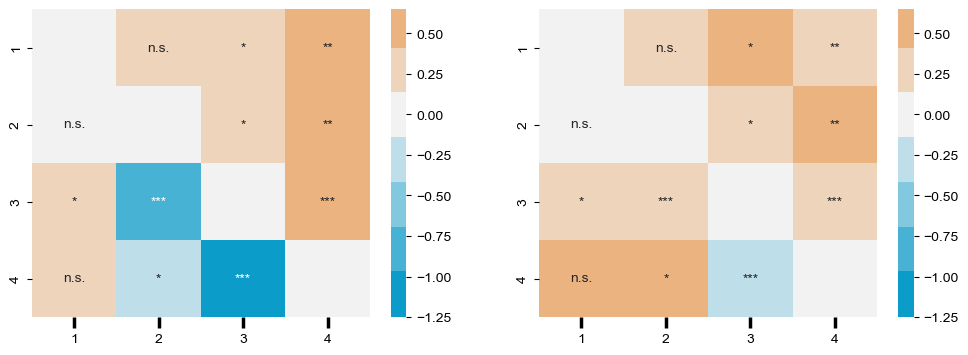

In [31]:
# plot interaction coefficients between ARE and Let-7
f, axs = plt.subplots(ncols = 2, figsize = (12, 4))

# Create a custom diverging palette
custom_palette = sns.diverging_palette(230, 30, s=99, l=60, sep = 10, n=9)

# heatmap for models of all reporters
sns.heatmap(
    ARE_LET7, 
    cmap = custom_palette,
    center = 0, 
    annot = ARE_LET7_pval,
    fmt = '',
    vmin = -1.25,
    vmax = 0.65,
    ax = axs[0]
)

# heatmap for models of not spliced reporter
sns.heatmap(
    ARE_LET7_ns, 
    cmap = custom_palette,
    center = 0, 
    annot = ARE_LET7_pval_ns,
    fmt = '',
    vmin = -1.25,
    vmax = 0.65,
    ax = axs[1]
)

f.savefig('PLOTS/Fig_S6B.pdf', transparent = True)

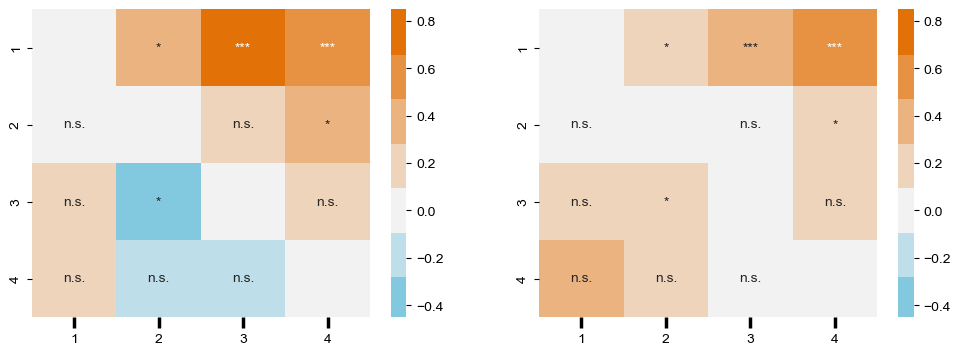

In [36]:
# plot interaction coefficients between ARE and PRE
f, axs = plt.subplots(ncols = 2, figsize = (12, 4))

# Create a custom diverging palette
custom_palette = sns.diverging_palette(230, 30, s=99, l=60, sep = 10, n=9)

# heatmap for models of all reporters
sns.heatmap(
    ARE_PUM, 
    cmap = custom_palette,
    center = 0, 
    annot = ARE_PUM_pval,
    fmt = '',
    vmin = -0.45,
    vmax = 0.85,
    ax = axs[0]
)

# heatmap for models of not spliced reporter
sns.heatmap(
    ARE_PUM_ns, 
    cmap = custom_palette,
    center = 0, 
    annot = ARE_PUM_pval_ns,
    fmt = '',
    vmin = -0.45,
    vmax = 0.85,
    ax = axs[1]
)

f.savefig('PLOTS/Fig_S6C.pdf', transparent = True)